# Motor RNNs

Base code borrowed from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

To do: look at different kinds of feedback from og code -- including feedback learning (feedback type 6)


## Setup

In [1]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# @title Set the project path
proj_path = "proj_rnn/"
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

## Utils

### Network

In [3]:
# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        order[0:48] = np.repeat([0,1,2,3,4,5], 8)   # uncomment for 0000000 111111 222....
        # order[0:48] = np.tile([0,1,2,3,4,5], 8)   # uncomment for 012345 012345 ...
        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # #depending on trial number, hide the x or y coordinate
                    # trial_num_within20 = t % 20
                    # if trial_num_within20 >= 12 and trial_num_within20 < 15:
                    #     errc[0] = np.zeros_like(errc[0])
                    # if trial_num_within20 >= 15 and trial_num_within20 < 18:
                    #     errc[1] = np.zeros_like(errc[1])
                    # print(errc)

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss
    
    def relearn_IF(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)
        
        order[0:48] = np.repeat([0,1,2,3,4,5], 8)   # uncomment for 0000000 111111 222....
        # order[0:48] = np.tile([0,1,2,3,4,5], 8)   # uncomment for 012345 012345 ...
        
        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # #depending on trial number, hide the x or y coordinate
                    if t < 70:
                        trial_num_within4 = t % 4
                        if trial_num_within4 == 1:
                            errc[0] = np.zeros_like(errc[0])
                        if trial_num_within4 == 2:
                            errc[1] = np.zeros_like(errc[1])
                        # print(errc)

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm

            # tape loss
            record_loss[t] = loss
            print('IF Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

In [4]:
# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

def create_reaching_task_decoder(reaching_network, n_output_units:int=2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""

  # set parameters
  SCALE = 0.04
  DENOM = 0.2

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)
  initial_decoder_fac = SCALE * (target_max / DENOM)

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))
  return reaching_decoder

def train_force_exertion_decoder(inputP, target, order, n_output:int=1):
    """train the decoder to perform the force exertion
    motor task. The network must apply force at
    oscillating amplitude (following a sinewave function
    of time)
    """

    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X, Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

In [5]:
# @title Feedback weights
def get_feedback_weights(decoder):
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

In [6]:
# @title Loss function
def get_cost(result, target, order):
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

def select_random_perturbations(activity2,D,P):    
    runs = 100 # number of random seeds  #CHANGED FROM 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

In [7]:
# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def save_reaching_manifold_IF(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results_IF', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  result = manifold_out["activity_reshaped"] @ transformed.T
  cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

In [8]:
# @title simulation
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

# @title simulation IF
def simulate_reaching_IF(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results_IF.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching_IF');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

### Task

In [9]:
# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginnning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])

  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)
  fig.tight_layout()

In [10]:
# @title "force" task
def create_force_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=1, amplitude:float=1., twod:bool=False):
    """create a stimulus set

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float)
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimuli
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    for j in range(n_targets):
        stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def plot_force_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginnning of each trial
  stimulus_set = np.arange(0, n_targets, 1)
  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))
  for target in stimulus_set:

    # plot
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)
  axes[-1].set_xlabel("time within a trial (secs)")
  fig.tight_layout()
  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def create_force_task_targets(tsteps, pulse_steps, targets:list=[1, 10], target_max:float=0.2):
  """exert force with an oscillatorily increasing and decreasing amplitude
  """
  n_targets = len(targets)
  rs = np.zeros(tsteps)
  traj = np.zeros((n_targets, tsteps, 1))
  rs[pulse_steps:] = np.ones(tsteps - pulse_steps) * target_max
  x_coord = np.linspace(-2*np.pi, 2*np.pi, tsteps, endpoint=False)
  freq = []
  for ix in range(n_targets):
    traj[ix,:,0] = rs * np.sin(targets[ix] * x_coord)
  return traj

def plot_force_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6));
  for target_i in tuple(range(n_targets)):

    # plot
    axes[target_i].plot(target[target_i,:,:]);

    # legend
    axes[target_i].set_xticks([0, tsteps]);
    axes[target_i].set_xticklabels([0, T]);
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9);
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01]);
  axes[-1].set_xlabel("time within a trial (secs)");
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False);
  fig.tight_layout();

## Create 

## Create task 1: "reaching"

In [11]:
# @title set parameters
# TODO: create dictionary

seed_id = 456                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.07                   # unit time constant tau (secs) changed from 0.1
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'constant'  # constant, linear, normal
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 100       # initial network learning     CHANGED from 80
delta = 20.
relearning_trials = 100      # relearning         CHANGED from 80
deltarec = 20.
alphas = np.array([0.25,0.5,0.75,1.])

# analyses parameters
manifold_trials = 80        # manifold calculation      CHANGED from 50
reduced_dim = 10

stimuli:
-a set of 6 possible trial stimuli (panels)
-200 timesteps within a trial stimulus
-6 possible cued target in a trial stimulus


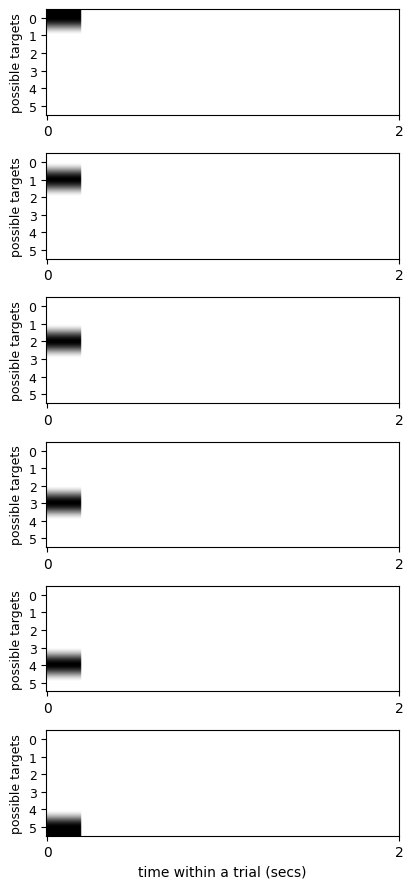

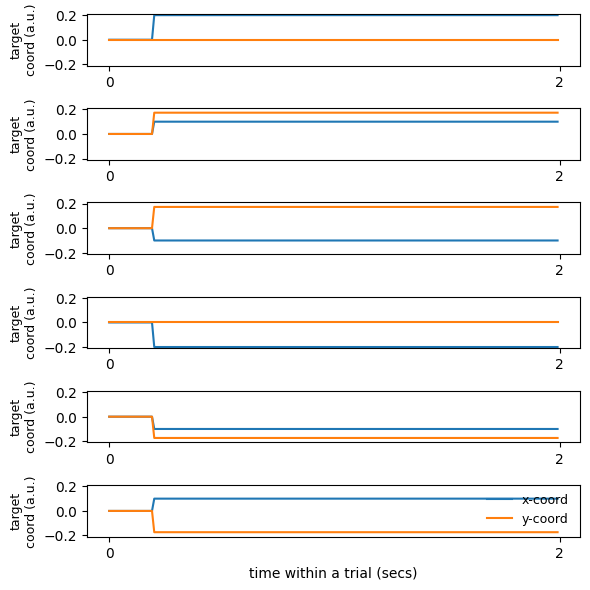

In [12]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, twod=False)
plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
target = create_reaching_task_targets(
    tsteps,
    pulse_length,
    n_targets=targets,
    stype=stimulus_type,
    target_max=target_max
    )
plot_reaching_task_targets(target, tsteps, T)

run normal

In [13]:
# @title build and train the network
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network,
                                                n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

# get the RNN's manifold
manifold_out = get_manifold(reaching_network)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, n_output_units=N_OUTPUT_UNITS)

manifold = {'original':{'activity':manifold_out["activity"],
                'activity2':manifold_out["activity_reshaped"],
                'xi':manifold_out["xi"],
                'xi2':manifold_out["xi2"],
                'cov':manifold_out["cov"],'ev':manifold_out["ev"],'evec':manifold_out["evec"],'pr':manifold_out["pr"],'order':manifold_out["order"]}}

Loss in Trial 1 is 0.28148
Loss in Trial 2 is 0.03653
Loss in Trial 3 is 0.03381
Loss in Trial 4 is 0.01385
Loss in Trial 5 is 0.02333
Loss in Trial 6 is 0.01744
Loss in Trial 7 is 0.07288
Loss in Trial 8 is 0.01040
Loss in Trial 9 is 0.53505
Loss in Trial 10 is 0.06804
Loss in Trial 11 is 0.02024
Loss in Trial 12 is 0.01417
Loss in Trial 13 is 0.02204
Loss in Trial 14 is 0.01971
Loss in Trial 15 is 0.06688
Loss in Trial 16 is 0.01403
Loss in Trial 17 is 0.65565
Loss in Trial 18 is 0.30507
Loss in Trial 19 is 0.11307
Loss in Trial 20 is 0.05047
Loss in Trial 21 is 0.06114
Loss in Trial 22 is 0.03038
Loss in Trial 23 is 0.04366
Loss in Trial 24 is 0.08699
Loss in Trial 25 is 0.40701
Loss in Trial 26 is 0.11307
Loss in Trial 27 is 0.06474
Loss in Trial 28 is 0.06829
Loss in Trial 29 is 0.03431
Loss in Trial 30 is 0.03912
Loss in Trial 31 is 0.04102
Loss in Trial 32 is 0.02081
Loss in Trial 33 is 0.60046
Loss in Trial 34 is 0.27465
Loss in Trial 35 is 0.29906
Loss in Trial 36 is 0.08351
L

run incomplete feedback

In [14]:
# @title build and train the network
# create and save RNN encoder
reaching_network_IF = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network_IF, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder_IF = create_reaching_task_decoder(reaching_network_IF,
                                                n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback_IF = get_feedback_weights(reaching_decoder_IF)

# train and save the RNN encoder weights (learn the task)
reaching_loss_IF = reaching_network_IF.relearn_IF(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder_IF,
                                         reaching_feedback_IF, target, delta=delta)
np.save(f'{savedir}W_stabilized_reaching_IF', reaching_network_IF.W)
w1_reaching_IF = reaching_network_IF.W.copy()

# get the RNN's manifold
manifold_out_IF = get_manifold(reaching_network_IF)

# train the decoder
W_bci4_IF, l4_IF = train_reaching_decoder(manifold_out_IF["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out_IF["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed_IF = transform_reaching(reaching_network_IF, manifold_out_IF,
                                 W_bci4_IF, n_output_units=N_OUTPUT_UNITS)

manifold_IF = {'original':{'activity':manifold_out_IF["activity"],
                'activity2':manifold_out_IF["activity_reshaped"],
                'xi':manifold_out_IF["xi"],
                'xi2':manifold_out_IF["xi2"],
                'cov':manifold_out_IF["cov"],'ev':manifold_out_IF["ev"],'evec':manifold_out_IF["evec"],'pr':manifold_out_IF["pr"],'order':manifold_out_IF["order"]}}

IF Loss in Trial 1 is 0.29734
IF Loss in Trial 2 is 0.00475
IF Loss in Trial 3 is 0.02504
IF Loss in Trial 4 is 0.01661
IF Loss in Trial 5 is 0.03111
IF Loss in Trial 6 is 0.00466
IF Loss in Trial 7 is 0.03750
IF Loss in Trial 8 is 0.01298
IF Loss in Trial 9 is 0.55184
IF Loss in Trial 10 is 0.03199
IF Loss in Trial 11 is 0.04176
IF Loss in Trial 12 is 0.05380
IF Loss in Trial 13 is 0.04479
IF Loss in Trial 14 is 0.01178
IF Loss in Trial 15 is 0.02083
IF Loss in Trial 16 is 0.02647
IF Loss in Trial 17 is 0.57330
IF Loss in Trial 18 is 0.06979
IF Loss in Trial 19 is 0.12192
IF Loss in Trial 20 is 0.15797
IF Loss in Trial 21 is 0.06026
IF Loss in Trial 22 is 0.06553
IF Loss in Trial 23 is 0.05033
IF Loss in Trial 24 is 0.11046
IF Loss in Trial 25 is 0.64481
IF Loss in Trial 26 is 0.06140
IF Loss in Trial 27 is 0.16958
IF Loss in Trial 28 is 0.09281
IF Loss in Trial 29 is 0.33136
IF Loss in Trial 30 is 0.02637
IF Loss in Trial 31 is 0.04236
IF Loss in Trial 32 is 0.08791
IF Loss in Trial 

save run data

In [15]:
# @title Save run data normal
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)


save run data IF

In [16]:

# @title Save run data IF
# format and save data for this run
run_data_IF = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder_IF,
        'feedback':reaching_feedback_IF,
        'stabilize_loss':reaching_loss_IF
        },
    'manifold':{
        'activity':manifold_out_IF["activity"],
        'activity2':manifold_out_IF["activity_reshaped"],
        'xi':manifold_out_IF["xi"],
        'xi2':manifold_out_IF["xi2"],
        'cov':manifold_out_IF["cov"],
        'ev':manifold_out_IF["ev"],
        'evec':manifold_out_IF["evec"],
        'pr':manifold_out_IF["pr"],
        'order': manifold_out_IF["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4_IF,
        'loss':l4_IF
        }
        }
np.save(f'{savedir}reaching_experiment_results_IF', run_data_IF)

# save manifold data separately
save_reaching_manifold_IF(run_data_IF, transformed_IF)

### simulate reaching

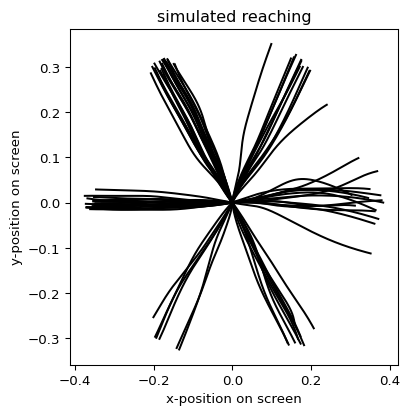

In [17]:
# simulate reaching
trajectories = simulate_reaching(savedir, dt)

simulate reaching IF

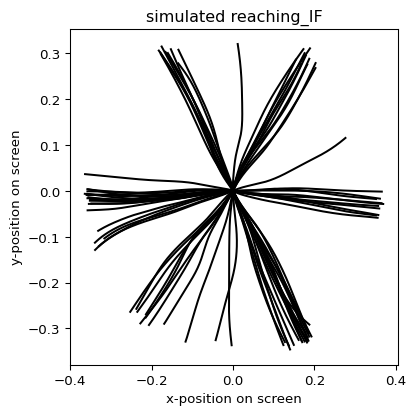

In [18]:
trajectories_IF = simulate_reaching_IF(savedir, dt)

plot losses over last 10 trials


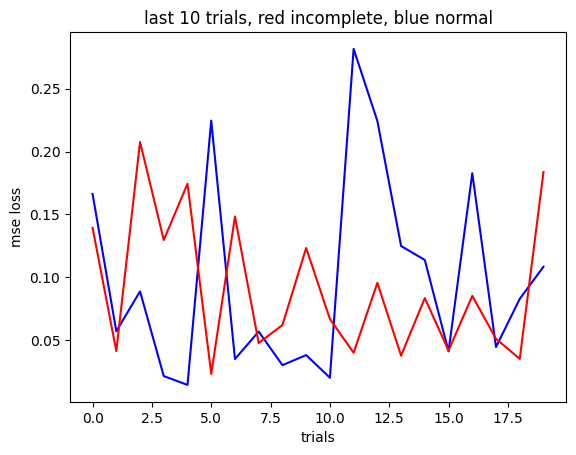

0.09776381687466436
0.09077917666074466


In [19]:
# last 10 trials
plt.plot(reaching_loss[80:],'b')
plt.plot(reaching_loss_IF[80:],'r')
plt.xlabel("trials")
plt.ylabel("mse loss")
plt.title("last 10 trials, red incomplete, blue normal")
plt.show()

# print(reaching_loss_IF[80:])
print(np.mean(reaching_loss[80:]))
print(np.mean(reaching_loss_IF[80:]))

plot all 80 trials

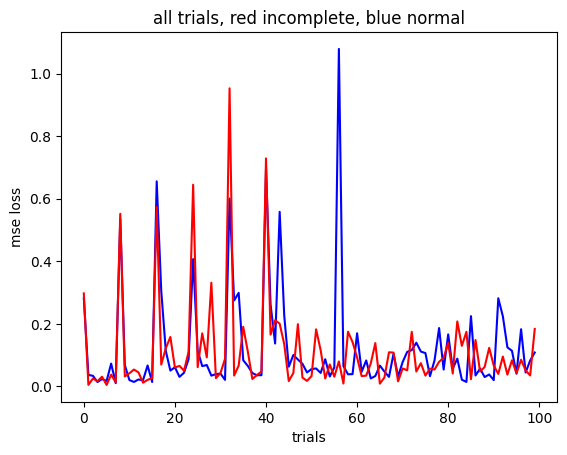

0.12233945207540362
0.11127052189468173


In [20]:
plt.plot(reaching_loss,'b')
plt.plot(reaching_loss_IF,'r')
plt.xlabel("trials")
plt.ylabel("mse loss")
plt.title("all trials, red incomplete, blue normal")
plt.show()

print(np.mean(reaching_loss))
print(np.mean(reaching_loss_IF))

## Add perturbations 

In [21]:
# original transformation
evec = manifold_out["evec"]
activity2 = manifold_out["activity_reshaped"]
order = manifold_out["order"]
network = reaching_network
w1 = w1_reaching


P = evec.real.T
D = np.zeros((2,network.N))
D[:,:reduced_dim] = W_bci4
T = D @ P
result_original = activity2 @ T.T
cost_original = get_cost(result_original,target[:,pulse_length:,:],order)
  
# select equal perturbation result shuffling seeds
idx_shuffling_seeds = select_random_perturbations(activity2,D,P) # within, outside

# within-manifold perturbation
costs_within = []
for i in range(10):
    within_seed = idx_shuffling_seeds[i,0] # 79
    np.random.seed(within_seed)
    perm_matrix_within = np.eye(reduced_dim)
    np.random.shuffle(perm_matrix_within)
    D_permute = D.copy()
    D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
    T_within = D_permute @ P
    result_within = activity2 @ T_within.T
    cost_within = get_cost(result_within,target[:,pulse_length:,:],order)
    costs_within.append(cost_within)



add perturbations IF

In [22]:
print(result_original.shape)

(80, 180, 2)


In [23]:
# original transformation
evec_IF = manifold_out_IF["evec"]
activity2_IF = manifold_out_IF["activity_reshaped"]
order_IF = manifold_out_IF["order"]
network_IF = reaching_network_IF
w1_IF = w1_reaching_IF


P_IF = evec_IF.real.T
D_IF = np.zeros((2,network_IF.N))
D_IF[:,:reduced_dim] = W_bci4
T_IF = D_IF @ P_IF
result_original_IF = activity2_IF @ T_IF.T
cost_original_IF = get_cost(result_original_IF,target[:,pulse_length:,:],order_IF)
  
# select equal perturbation result shuffling seeds
idx_shuffling_seeds_IF = select_random_perturbations(activity2_IF,D_IF,P_IF) # within, outside
costs_within_IF = []
# within-manifold perturbation
for i in range(10):
    within_seed_IF = idx_shuffling_seeds_IF[i,0] # 79
    np.random.seed(within_seed_IF)
    perm_matrix_within_IF = np.eye(reduced_dim)
    np.random.shuffle(perm_matrix_within_IF)
    D_permute_IF = D_IF.copy()
    D_permute_IF[:reduced_dim,:reduced_dim] = D_IF[:reduced_dim,:reduced_dim] @ perm_matrix_within_IF
    T_within_IF = D_permute_IF @ P_IF
    result_within_IF = activity2_IF @ T_within_IF.T
    cost_within_IF = get_cost(result_within_IF,target[:,pulse_length:,:],order)
    costs_within_IF.append(cost_within_IF)

plot the test set loss appended with the within manifold loss
- 10 within manifold trials

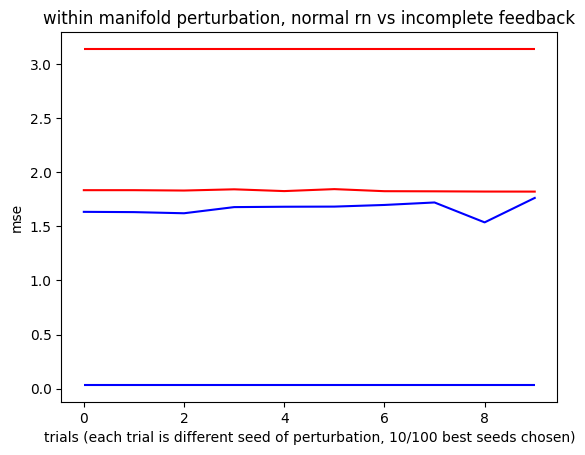

In [24]:
plt.plot(costs_within,'b')
plt.plot(costs_within_IF,'r')
plt.hlines(cost_original,0, len(costs_within) - 1,'b')
plt.hlines(cost_original_IF,0, len(costs_within) - 1,'r')
plt.title("within manifold perturbation, normal rn vs incomplete feedback")
plt.xlabel("trials (each trial is different seed of perturbation, 10/100 best seeds chosen)")
plt.ylabel("mse")
plt.show()

## Implement Incremental Learning   

In [ ]:
w_outside = []
fb_outside_rec = []
cost_outside_retrained = []
cost_inc_retrained = []
fb_corr = []
exp_var = []
exp_var_new = []
for j in range(len(alphas)):
    print('Run %d'%(j+1))
    # set incremental BCI
    Tinc = (1-alphas[j])*T + (alphas[j])*T_outside
    Pinc = np.linalg.pinv(D) @ Tinc
    # RETRAIN
    network.W = np.copy(w1) # start from initial training setup
    fb_outside = np.linalg.pinv(Tinc) # take correct feedback for retraining
    # recurrent relearning
    loss_outside = network.relearn(relearning_trials, stimulus, pulse_length, 
                      Tinc, fb_outside, target, delta=deltarec)
    w_outside.append(np.copy(network.W))
    
    # TESTING 
    # simulate new activiy data 
    activityt,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials, 
                                                                  ext=stimulus, ntstart=pulse_length)
    manifold.update({'outside'+str(j+1):{'activity':activityt,'order':order,
                           'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
    # reshape
    activity2t = activityt.reshape(manifold_trials,-1,network.N)
    # calculate output
    result_outside = activity2t @ T_outside.T
    cost_outside_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))
    # calculate output
    result_outside = activity2t @ Tinc.T
    cost_inc_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))

    # calculate explained variance
    proj1 = manifold['original']['evec'].T @ cov @ manifold['original']['evec']
    proj2 = manifold['original']['evec'].T @ manifold['original']['cov'] @ manifold['original']['evec']
    proj3 = Pinc @ cov @ Pinc.T     
    match1 = np.trace(proj1[:reduced_dim])/np.trace(cov)
    match2 = np.trace(proj2[:reduced_dim])/np.trace(manifold['original']['cov'])
    match3 = np.trace(proj3[:reduced_dim])/np.trace(cov)
    exp_var.append(match1/match2)
    exp_var_new.append(match3/match2)

    print('Goal: %.2f --- Outside: %.2f --- Incremental: %.2f'%(cost_original,
                    cost_outside_retrained[-1],cost_inc_retrained[-1]))
    print('Manifold match old: %.2f --- Manifold match new: %.2f'%(exp_var[-1],exp_var_new[-1]))

# save it
temp_data = {'alphas':alphas,'fb_corr':fb_corr,'exp_var':exp_var,
             'exp_var_new':exp_var_new,
             'cost_outside_retrained':cost_outside_retrained,
             'cost_inc_retrained':cost_inc_retrained,
             'T':T,'D':D,'P':P,'T_outside':T_outside}
# np.save(savdir+'results',temp_data)
# np.save(savdir+'manifold',manifold) 
# np.save(savdir+'wOM',w_outside)
# np.save(savdir+'wfbOM',fb_outside)

## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?